# A Million News Headlines

This contains data of news headlines published over a period of 15 years.

Sourced from the reputable Australian news source ABC (Australian Broadcasting Corp.)

Agency Site: http://www.abc.net.au/

## Data Description
- Format: CSV ; Single File

- publish_date: Date of publishing for the article in yyyyMMdd format
- headline_text: Text of the headline in Ascii , English , lowercase
- Start Date: 2003-02-19 End Date: 2017-12-31

Total Records: 1,103,663

Feed-Code: w3-event-abcaus; Si.gh.rank: SND

## Import Module

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data Import

In [2]:
data = pd.read_csv("abcnews-date-text.csv")

In [3]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [4]:
data_sort = data.sort_values("publish_date",axis=0,ascending=True,kind='quicksort',na_position='last')

In [5]:
data_sort.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
126,20030219,patterson snubs health meeting to avoid lions den
127,20030219,peace agreement may bring respite for venezuela
128,20030219,pienaar shines as ajax frustrate arsenal
129,20030219,plan for second skatepark


## Data Processing

In [6]:
from bs4 import BeautifulSoup
#Remove HTML tags and URL from the reviews.
def html_tag(phrase):
    http_remove = re.sub(r"http\S+", "",phrase)
    html_remove = BeautifulSoup(http_remove, 'lxml').get_text()
    return html_remove

In [7]:
import re
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [9]:
from tqdm import tqdm_notebook as tqdm

In [10]:
processed_text = []
for i in tqdm(data["headline_text"].values):
    sentance = html_tag(i)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance)
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = " ".join(i.lower() for i in sentance.split() if i.lower() not in stopwords)
    processed_text.append(sentance)

In [11]:
data["Clean_text"] = processed_text

In [12]:
data.head()

,publish_date,headline_text,Clean_text
0,20030219,aba decides against community broadcasting lic...,aba decides community broadcasting licence
1,20030219,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation
2,20030219,a g calls for infrastructure protection summit,g calls infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise
4,20030219,air nz strike to affect australian travellers,air nz strike affect australian travellers


### Word-Cloud

In [13]:
def word_cloud(cluster_num):
    sentance = []
    num = cluster_num
    sent = final_data["Clean_text"][final_data["labels"]==num]
    for i in sent:
        sentance.append(i)
    sentance = ''.join(sentance)
    wordcloud = WordCloud(background_color="white").generate(sentance)
    print(f"Cluster Number: {num}")
    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Bag-Of-Word (BOW)

In [14]:
from wordcloud import WordCloud
from sklearn.cluster import KMeans
final_data = data[0:100000]
bow = CountVectorizer(ngram_range=(1,2))
bow_vector = bow.fit_transform(final_data["Clean_text"])

In [15]:
clusters = [2,3,4,5,6,7,8,9]
inertia = []
for i in tqdm(clusters):
    k_mean= KMeans(n_clusters=i,n_init=10)
    k_mean.fit(bow_vector)
    inertia.append(k_mean.inertia_)

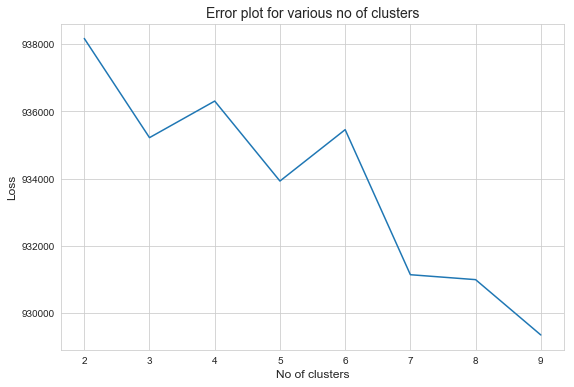

In [16]:
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.lineplot(clusters,inertia)
plt.xlabel("No of clusters",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.title("Error plot for various no of clusters",fontsize=14)
plt.show()

In [17]:
k_mean = KMeans(n_clusters=5,n_init=10)
k_mean.fit(bow_vector)
final_data["labels"] = k_mean.labels_

## Word-Cloud

Cluster Number: 0


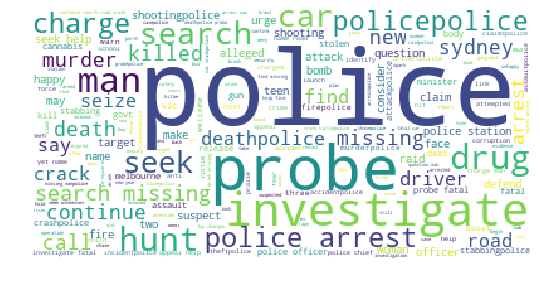

In [18]:
word_cloud(0)

Cluster Number: 1


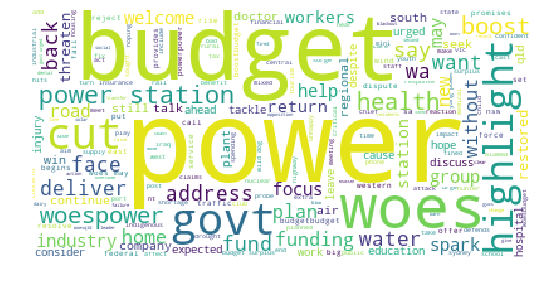

In [19]:
word_cloud(1)

Cluster Number: 2


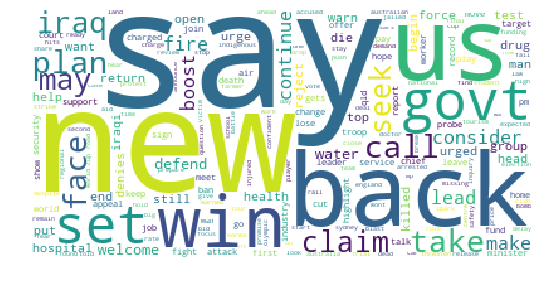

In [20]:
word_cloud(2)

Cluster Number: 3


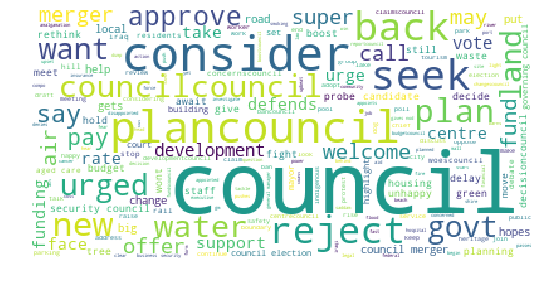

In [21]:
word_cloud(3)

Cluster Number: 4


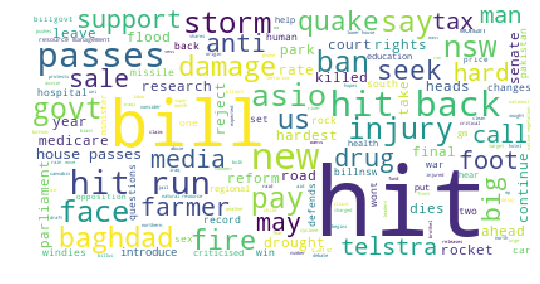

In [22]:
word_cloud(4)

## Observation
1. First image is related with some police investication, arrest and crimes scenarios.
2. Figure 2 and 3 makes no sense.
3. Figure 4 implies government policies and orders.
4. Figure 5 implies natural calamities, destruction and injuries.

# TFIDF

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Nowadays, tf-idf is one of the most popular term-weighting schemes; 83% of text-based recommender systems in the domain of digital libraries use tf-idf.

In [23]:
tfidf = TfidfVectorizer()
tfidf_vector = tfidf.fit_transform(final_data["Clean_text"])

In [24]:
clusters = [2,3,4,5,6,7,8,9]
inertia = []
for i in tqdm(clusters):
    k_mean= KMeans(n_clusters=i,n_init=10)
    k_mean.fit(tfidf_vector)
    inertia.append(k_mean.inertia_)

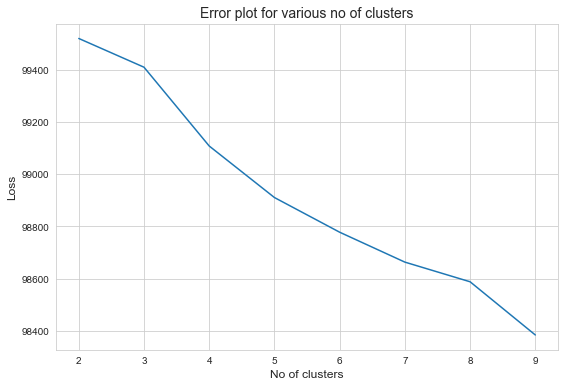

In [25]:
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.lineplot(clusters,inertia)
plt.xlabel("No of clusters",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.title("Error plot for various no of clusters",fontsize=14)
plt.show()

In [26]:
final_data.drop(columns='labels',axis=1,inplace=True)
k_mean = KMeans(n_clusters=8,n_init=10)
k_mean.fit(tfidf_vector)
final_data["labels"] = k_mean.labels_

unique_labels = list(final_data["labels"].unique())
unique_labels.sort()

## Word-Cloud

Cluster Number: 0


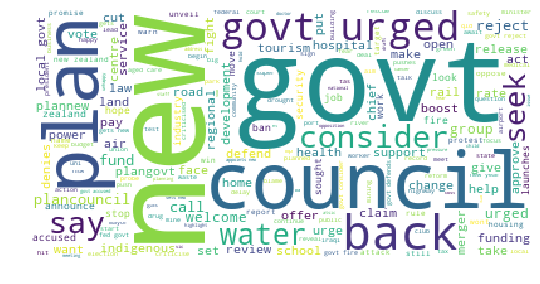

In [27]:
word_cloud(0)

Cluster Number: 1


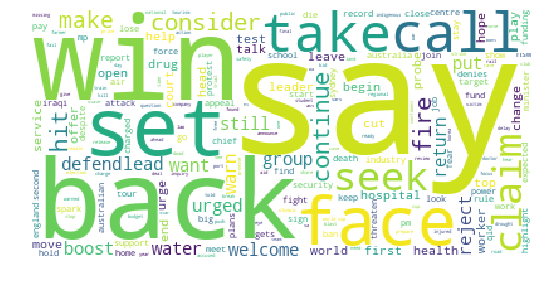

In [28]:
word_cloud(1)

Cluster Number: 2


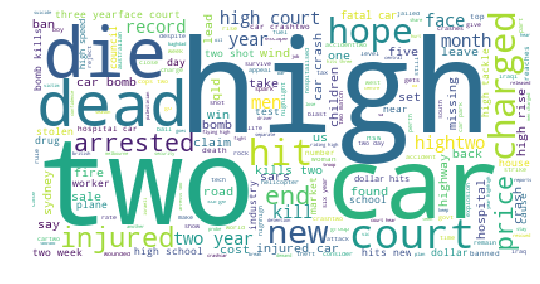

In [29]:
word_cloud(2)

Cluster Number: 3


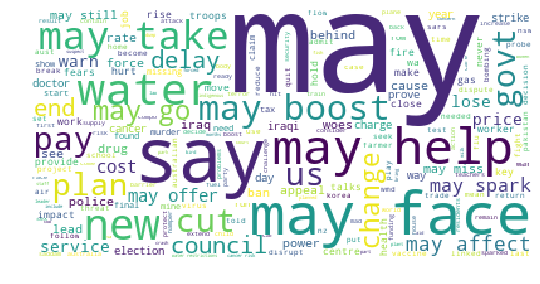

In [30]:
word_cloud(3)

Cluster Number: 4


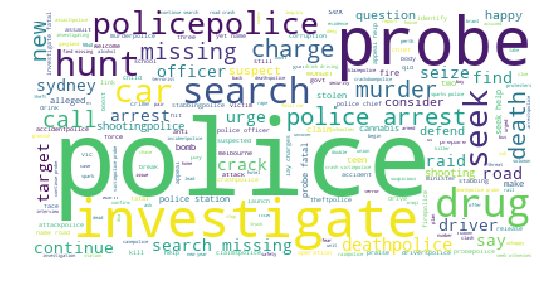

In [31]:
word_cloud(4)

Cluster Number: 5


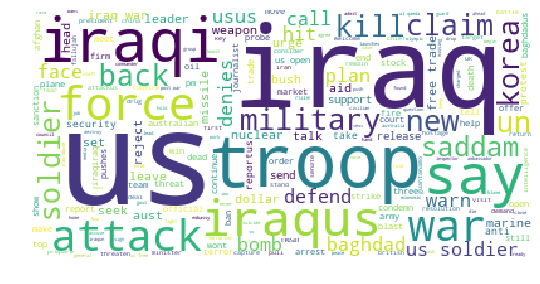

In [32]:
word_cloud(5)

Cluster Number: 6


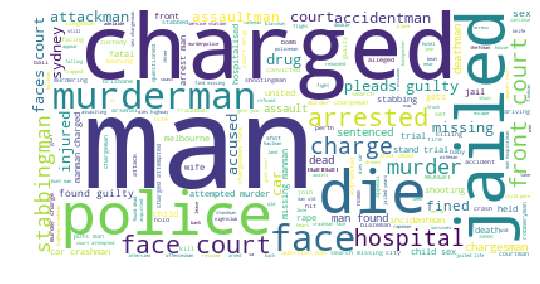

In [33]:
word_cloud(6)

Cluster Number: 7


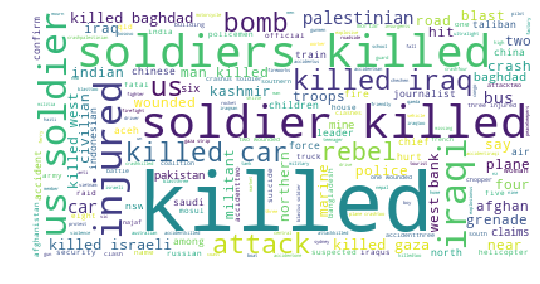

In [34]:
word_cloud(7)

## Observation
- Image 1 related with government policies, orders and decision.
- Image 2 and 4 makes no sense.
- Image 3 clearly shows it was related with accidents, crashs, and fatal reports.
- Image 5 and 7 shows, the corresponding clusters are classified into the topics of Police Investigations, Crime and murders.
- From the 6th wordcloud image, it clearly indicates the news were correctly clustered into the topics of Iraqi War, US Soldiers and military related topics.
- 8th image show that, among 1 Million news Terrorism related news were correctly clustered.


# Average Word2Vector

In [35]:
list_of_sentance=[]
for sentance in tqdm(final_data["Clean_text"]):
    list_of_sentance.append(sentance.split())
x = final_data["Clean_text"]
print(f"Shape of X Train : {x.shape}")
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
w2v_vector = []
for sent in tqdm(list_of_sentance):
    word_count = 0
    word_vector = np.zeros(50)
    for words in sent:
        if words in w2v_words:
            word_count +=1 
            each_word_vect = w2v_model.wv[words]
            word_vector += each_word_vect
    if word_count != 0: 
        word_vector /= word_count
    w2v_vector.append(word_vector)
print(f"Length of w2v_vector: {len(w2v_vector)}")


Shape of X Train : (100000,)



Length of w2v_vector: 100000


In [36]:
clusters = [2,3,4,5,6,7,8,9]
inertia = []
for i in tqdm(clusters):
    k_mean= KMeans(n_clusters=i,n_init=10)
    k_mean.fit(w2v_vector)
    inertia.append(k_mean.inertia_)

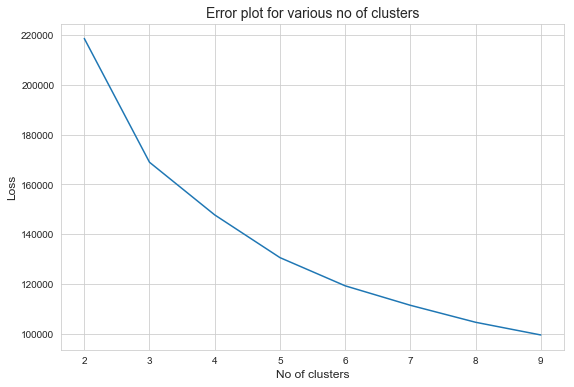

In [37]:
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.lineplot(clusters,inertia)
plt.xlabel("No of clusters",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.title("Error plot for various no of clusters",fontsize=14)
plt.show()

In [38]:
final_data.drop(columns='labels',axis=1,inplace=True)
k_mean = KMeans(n_clusters=5,n_init=10)
k_mean.fit(w2v_vector)
final_data["labels"] = k_mean.labels_
unique_labels = list(final_data["labels"].unique())
unique_labels.sort()

## Word-Cloud

Cluster Number: 0


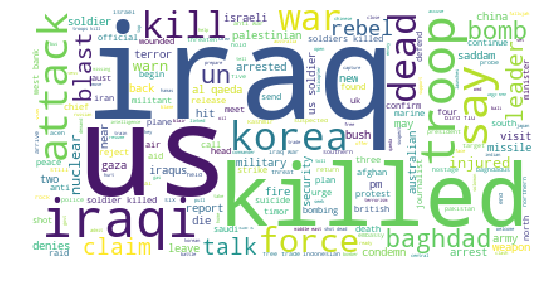

In [39]:
word_cloud(0)

Cluster Number: 1


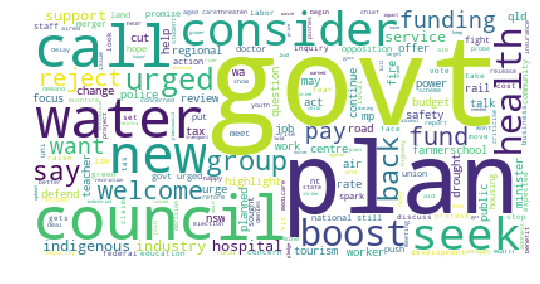

In [40]:
word_cloud(1)

Cluster Number: 2


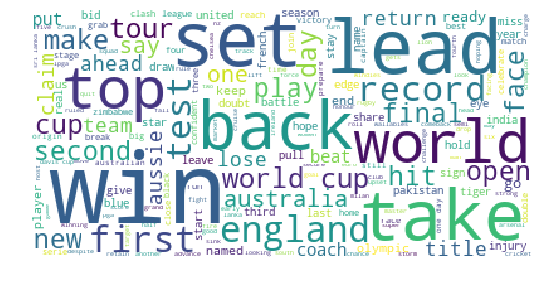

In [41]:
word_cloud(2)

Cluster Number: 3


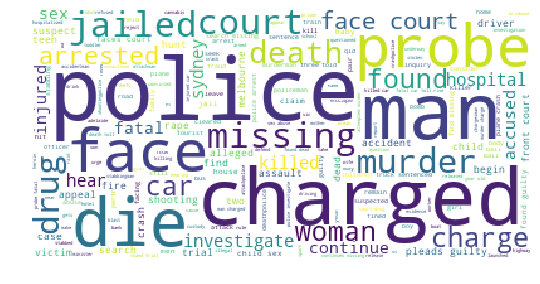

In [42]:
word_cloud(3)

Cluster Number: 4


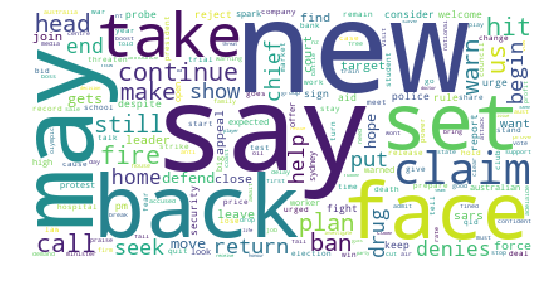

In [43]:
word_cloud(4)

In [44]:
final_data.drop(columns='labels',axis=1,inplace=True)

## Observation
- 1st Clusters are related with US Soldiers, War, Iraq war and fatal report topics.
- 2nd Clusters related with government policies, plans and decisions.
- 3rd Clusters are related with games.
- 4th Clusters are related with Polics Investigation, FIR, Crimes and its charges.

# TFIDF Weighted V2W

In [45]:
list_of_sentance=[]
for sentance in tqdm(final_data["Clean_text"]):
    list_of_sentance.append(sentance.split())
x = final_data["Clean_text"]
print(f"Shape of final_data: {x.shape}")

model = TfidfVectorizer()
model.fit(final_data["Clean_text"])
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


tfidf_w2v_vector = [];
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_vector.append(sent_vec)
print(f"Length of tfidf_w2v_vector {len(tfidf_w2v_vector)}")


Shape of final_data: (100000,)



Length of tfidf_w2v_vector 100000


In [46]:
clusters = [2,3,4,5,6,7,8,9]
inertia = []
for i in tqdm(clusters):
    k_mean= KMeans(n_clusters=i,n_init=10)
    k_mean.fit(tfidf_w2v_vector)
    inertia.append(k_mean.inertia_)

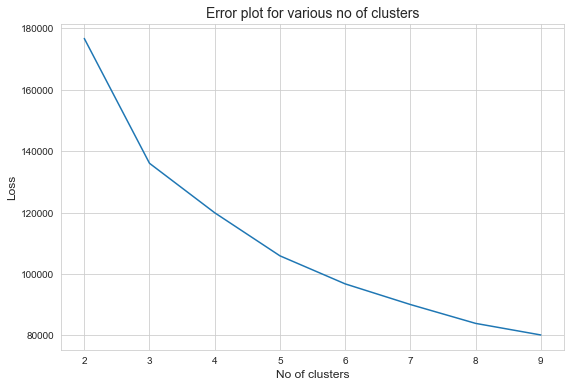

In [47]:
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.lineplot(clusters,inertia)
plt.xlabel("No of clusters",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.title("Error plot for various no of clusters",fontsize=14)
plt.show()

In [48]:
k_mean = KMeans(n_clusters=5,n_init=10)
k_mean.fit(tfidf_w2v_vector)
final_data["labels"] = k_mean.labels_
unique_labels = list(final_data["labels"].unique())
unique_labels.sort()

## Word-Cloud

Cluster Number: 0


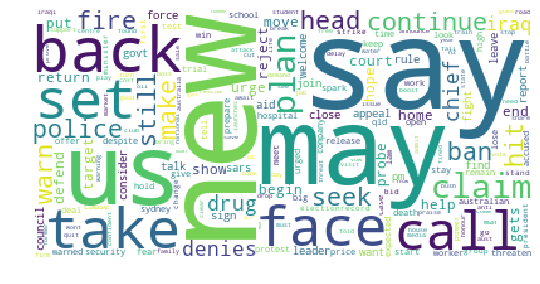

In [49]:
word_cloud(0)

Cluster Number: 1


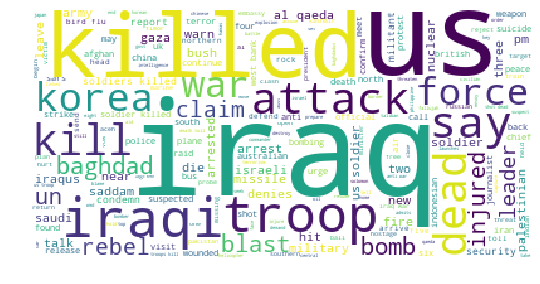

In [50]:
word_cloud(1)

Cluster Number: 2


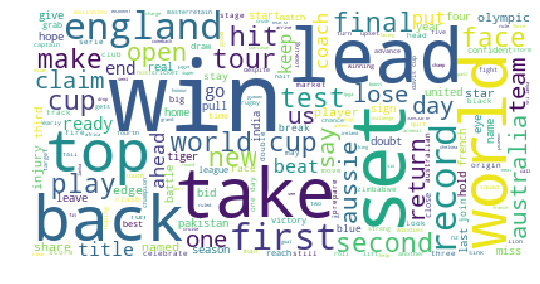

In [51]:
word_cloud(2)

Cluster Number: 3


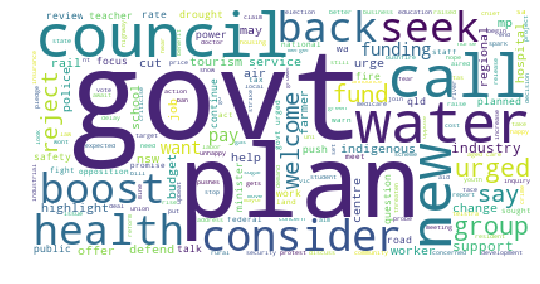

In [52]:
word_cloud(3)

Cluster Number: 4


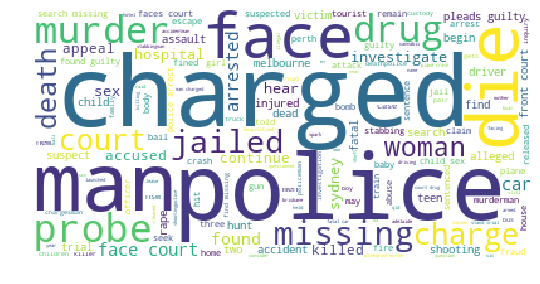

In [53]:
word_cloud(4)

## Observation
- 2st Clusters are related with US Soldiers, War, Iraq war and fatal report topics.
- 3nd Clusters are related with games.
- 4rd Clusters related with government policies, plans and decisions.
- 5th Clusters are related with Polics Investigation, FIR, Crimes and its charges.

# Conclusion

In [12]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Cluster", "News Topics"]
x.add_row(["Bag-Of-Word", 1, "Police investication, arrest and crimes scenarios"])
x.add_row(["Bag-Of-Word", 2, " "])
x.add_row(["Bag-Of-Word", 3, " "])
x.add_row(["Bag-Of-Word", 4, "Government policies and orders"])
x.add_row(["Bag-Of-Word", 5, "Natural calamities, destruction and injuries"])
print("Bag-Of-Words")
print(x)
x = PrettyTable()
x.field_names = ["Vectorizer", "Cluster", "News Topics"]
x.add_row(["TFIDF", 1, "Government policies, orders and decision"])
x.add_row(["TFIDF", 2, ""])
x.add_row(["TFIDF", 3, "Accidents, crashs, and fatal reports"])
x.add_row(["TFIDF", 4, " "])
x.add_row(["TFIDF", 5, "Police Investigations, Crime and murders."])
x.add_row(["TFIDF", 6, " Iraqi War, US Soldiers and military"])
x.add_row(["TFIDF", 7, "Police Investigations, Crime and murders"])
x.add_row(["TFIDF", 8, "Terrorism"])
print("TFIDF")
print(x)
x = PrettyTable()
x.field_names = ["Vectorizer", "Cluster", "News Topics"]
x.add_row(["Average Word2Vector", 1, "US Soldiers, War, Iraq war and fatal report"])
x.add_row(["Average Word2Vector", 2, "Government policies, plans and decisions"])
x.add_row(["Average Word2Vector", 3, "Games"])
x.add_row(["Average Word2Vector", 4, "Police Investigation, FIR, Crimes and its charges"])
x.add_row(["Average Word2Vector", 5, " "])
print("Average TFIDF")
print(x)
x = PrettyTable()
x.field_names = ["Vectorizer", "Cluster", "News Topics"]
x.add_row(["TFIDF-Word2Vector", 1, " "])
x.add_row(["TFIDF-Word2Vector", 2, "US Soldiers, War, Iraq war and fatal report"])
x.add_row(["TFIDF-Word2Vector", 3, "Games"])
x.add_row(["TFIDF-Word2Vector", 4, "Government policies, plans and decisions"])
x.add_row(["TFIDF-Word2Vector", 5, "Police Investigation, FIR, Crimes and its charges"])
print("TFIDF Weighted Word2Vector")
print(x)

Bag-Of-Words
+-------------+---------+---------------------------------------------------+
|  Vectorizer | Cluster |                    News Topics                    |
+-------------+---------+---------------------------------------------------+
| Bag-Of-Word |    1    | Police investication, arrest and crimes scenarios |
| Bag-Of-Word |    2    |                                                   |
| Bag-Of-Word |    3    |                                                   |
| Bag-Of-Word |    4    |           Government policies and orders          |
| Bag-Of-Word |    5    |    Natural calamities, destruction and injuries   |
+-------------+---------+---------------------------------------------------+
TFIDF
+------------+---------+-------------------------------------------+
| Vectorizer | Cluster |                News Topics                |
+------------+---------+-------------------------------------------+
|   TFIDF    |    1    |  Government policies, orders and decision |
|  